# Exploration of the binomial model for directionality

Based on the relative orientations of the reads of a read pair, we classify read pairs as either *simple* or *twisted*. For Hi-C and capture Hi-C data, there are roughly the same number of simple and twisted read pairs, after artifact read pairs (un-ligated, self-ligated, etc.) have been filtered out. On the other hand, there can be extreme imbalances of simple and twisted read pairs within individual interactions. We use a binomial test with $p=0.5$ to assess imbalances within individual interactions for statistical significance. For example, if an interaction has $s=5$ simple and $t=10$ twisted read pairs, then we use

$$B(k=s, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

with a certain P-value threshold to decide whether the interaction is directed or not. One problem with this approach is that interactions have different total numbers of read pairs ($n$) and that the power of the test increases with $n$.

In this Jupyter Notebook we examine the relationship between $n$ and the power of the test. For this purpose, we simulate interactions with simple and twisted read pairs by drawing the total number of read pairs ($n$) from a uniform ditribution and then choosing randomly a number of simple read pairs ($s<=n$) using our binomial model with $p=0.5$. Then we evaluate the simulated interactions with regard to directionality, also using our binomial model, and determine the number of directed interactions for each $n$ at a specified P-value threshold.

In addition, we determine the empirical distribution in a real dataset.


## Setting up the notebook

In [2]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
%alias_magic --line whereami pwd
%whereami

# Import BinomialInteractionModel
sys.path.append("..")
from diachr import BinomialInteractionModel

Created `%whereami` as an alias for `%pwd`.


## Simulation of interactions

First we create an object of class `BinomialInteractionModel`. Initially, the P-value threshold at which interactions are classified as directed is set and the minimum number of read pairs required for significance is determined. For example, if the threshold is $0.05$, then at least 5 read pairs are required for significance, because the most extreme P-value for 4 read pairs is already greater than the threshold ($0.0625$). We do not simulate interactions that have too few read pairs to be significant.





In [3]:
p_value_cutoff=0.0019
bim = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.0019.
	[INFO] Smallest n: 10 read pairs (0.0009765625)
[INFO] Parameters
	[INFO] _out_prefix: OUTPREFIX
	[INFO] _p_value_cutoff: 0.0019
	[INFO] _n_indef: 10
	[INFO] _pv_indef: 0.0009765625


Next we simulate the interactions. To do this, we need to set two parameters:

1. The maximum number of read pairs per interaction (`n_max`)
2. The number of interactions to be simulated (`i_num`)

We use the numpy function `randint` in order draw `i_num` total read pair numbers from a uniform distribution:

`np.random.randint(low = self._n_indef, high = n_max  + 1, size = i_num)`

Note that we only draw numbers that are greater or equal to the previously determined number of read pairs that are required for significance (`low = self._n_indef`).

The function returns a list and a dictionary.



In [6]:
n_max=200
i_num=100000
signum_list, N_DICT_SIM = bim.count_simulated_interactions(n_max=n_max, i_num=i_num)

[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


<p>signum_list contains the numbers of interactions that were found to be significant where the interactions contain the number
of read pairs as indicated by the index. We therefore plot the index on the x axis.</p>

In [7]:
idx_list = list(range(0,len(signum_list)))

In [8]:
len(idx_list)
len(N_DICT_SIM)

191

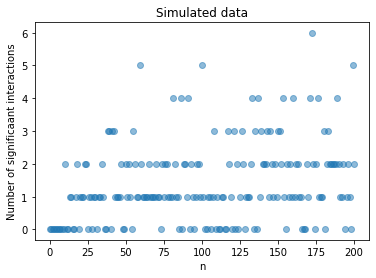

In [9]:
plt.scatter(idx_list, signum_list, alpha=0.5)
plt.title('Simulated data')
plt.xlabel('n')
plt.ylabel('Number of significaant interactions')
plt.show()

<h2>We generate a plot of empircal data</h2>

In [ ]:
# This should be a diachromatic enhanced interaction file
iefile = '../results/06_select_reference_interactions/MK/MK_enhanced_interaction_file_with_di_and_uir.tsv.gz'
if not os.path.exists(iefile):
    raise FileNotFoundError("Could not find IE file")

In [30]:
n_def_list, n_sig_list = bim.count_significant_empirical_interactions(eifile=iefile)

... done.
... done.


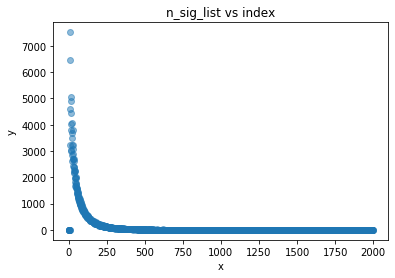

In [32]:
idx_list = list(range(0,len(n_sig_list)))

plt.scatter(idx_list, n_sig_list, alpha=0.5)
plt.title('n_sig_list vs index')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

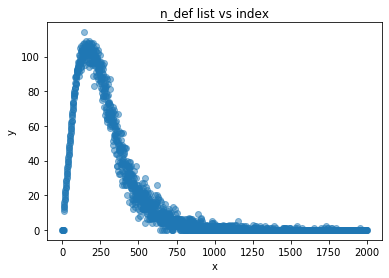

In [33]:
plt.scatter(idx_list, n_def_list, alpha=0.5)
plt.title('n_def list vs index')
plt.xlabel('x')
plt.ylabel('y')
plt.show()